In [ ]:
# import the necessary packages
import numpy as np
import gzip, os
from urllib.request import urlretrieve
from random import random
from math import exp
from random import seed
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
from torchvision.models import VGG
import time
import cv2
import torch.optim as optim
from tqdm import tqdm

# Part 1: Backpropagation in Neural Networks

#### Overview
Artificial Neural Networks are computational learning systems that uses a network of functions to understand and translate a data input of one form into a desired output, usually in another form. The concept of the artificial neural network was inspired by human biology and the way neurons of the human brain function together to understand inputs from human senses.

A simple neural network consists of Input Layer, Hidden Layer and Output Layer.
To train these the network, we will use Backpropagation algorithm.  Backpropagation is the cornerstone of modern neural networks. Reference:  *How the backpropagation algorithm works from Neural Networks and Deep Learning* (http://neuralnetworksanddeeplearning.com/chap2.html).


Architecture Definition :

*   An Input Layer with the following 2-dimensions:
  *  0: Batch Size
  *  1: 784 = 28*28 pixels
* A hidden layer with 500 units
* A second hidden layer with 50 units
* An output layer with 10 units

There are five major steps to the implementation:

1. Define neural network: initialize_network()

2. Forward Propagation: pre_activation(), sigmoid_activation(), forward_propagation()

3. Backpropagation: backward_propagate_error()

4. Loss function and updation of weights (SGD): update_weights()

5. Training: train()



## Data

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 11SpETIc56PReKuaUKEwWDvdkiynyyGFA
!unzip "/content/MNISTArchive.zip" -d "/content/"
!gzip -d "/content/t10k-labels-idx1-ubyte.gz"
!gzip -d "/content/t10k-images-idx3-ubyte.gz" 
!gzip -d "/content/train-labels-idx1-ubyte.gz"
!gzip -d "/content/train-images-idx3-ubyte.gz"

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=11SpETIc56PReKuaUKEwWDvdkiynyyGFA 

unzip:  cannot find or open /content/MNISTArchive.zip, /content/MNISTArchive.zip.zip or /content/MNISTArchive.zip.ZIP.
gzip: /content/t10k-labels-idx1-ubyte.gz: No such file or directory
gzip: /content/t10k-images-idx3-ubyte.gz: No such file or directory
gzip: /content/train-labels-idx1-ubyte.gz: No such file or directory
gzip: /content/train-images-idx3-ubyte.gz: No such file or directory


## Helper Functions:

### Code

In [ ]:
def read_mnist(path=None):
    r"""Return (train_images, train_labels, test_images, test_labels).

    Args:
        path (str): Directory containing MNIST. Default is
            /home/USER/data/mnist or C:\Users\USER\data\mnist.
            Create if nonexistant. Download any missing files.

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values.
            Columns of labels are a onehot encoding of the correct class.
    """
    url = 'http://yann.lecun.com/exdb/mnist/'
    files = ['train-images-idx3-ubyte.gz',
             'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz',
             't10k-labels-idx1-ubyte.gz']

    if path is None:
        # Set path to /home/USER/data/mnist or C:\Users\USER\data\mnist
        path = os.path.join(os.path.expanduser('~'), 'data', 'mnist')

    # Create path if it doesn't exist
    os.makedirs(path, exist_ok=True)

    # Download any missing files
    for file in files:
        if file not in os.listdir(path):
            urlretrieve(url + file, os.path.join(path, file))
            print("Downloaded %s to %s" % (file, path))

    def _images(path):
        """Return images loaded locally."""
        with gzip.open(path) as f:
            # First 16 bytes are magic_number, n_imgs, n_rows, n_cols
            pixels = np.frombuffer(f.read(), 'B', offset=16)
        return pixels.reshape(-1, 784).astype('float32') / 255

    def _labels(path):
        """Return labels loaded locally."""
        with gzip.open(path) as f:
            # First 8 bytes are magic_number, n_labels
            integer_labels = np.frombuffer(f.read(), 'B', offset=8)

        def _onehot(integer_labels):
            """Return matrix whose rows are onehot encodings of integers."""
            n_rows = len(integer_labels)
            n_cols = integer_labels.max() + 1
            onehot = np.zeros((n_rows, n_cols), dtype='uint8')
            onehot[np.arange(n_rows), integer_labels] = 1
            return onehot

        return _onehot(integer_labels)

    train_images = _images(os.path.join(path, files[0]))
    train_labels = _labels(os.path.join(path, files[1]))
    test_images = _images(os.path.join(path, files[2]))
    test_labels = _labels(os.path.join(path, files[3]))

    return train_images, train_labels, test_images, test_labels

In [ ]:
# Initialize a network
def initialize_network(n_inputs, n_hidden, n_outputs):
	network = list()
	hidden_layer = None
	## Write your code. Initialize hidden layer here.
	hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
	network.append(hidden_layer)
	output_layer = None
	## Write your code. Initialize output_layer layer here. 
	output_layer = [{'weights':[random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
	network.append(output_layer)
	return network

In [ ]:
# Calculate neuron activation for an input
def pre_activation(weights, inputs):
	activation = weights[-1]
	for i in range(len(weights)-1):
		## Write code here. compute activation: Wx+b
		activation += weights[i] * inputs[i]	
	return activation

def sigmoid_activation(activation):
	out_sigmoid=None
	## write code. implement sigmoid function
	out_sigmoid = 1.0 / (1.0 + exp(-activation))
	return out_sigmoid
 
# Calculate the derivative of a neuron output
def sigmoid_derivative(output):
	## write code. implement sigmoid function
	out_sigmoid_deriv = output * (1.0 - output)
	return out_sigmoid_deriv

def softmax(z):   ## softmax for the last layer
  total = 0
  for i in range(len(z)):
    z[i] = exp(z[i])
    total += z[i]
  return z/total

In [ ]:
# Forward Propagation:
def forward_propagation(network, row):
	inputs = row
	for layer in network:

		new_inputs = []
		
		## for each hidden neuron this 'layer', compute \
		## pre_activation, sigmoid_activation and save then output in 'new_inputs.'

		inputs = new_inputs
	return inputs

# Backpropagation:
def backward_propagate_error(network, ground_truth):
	for i in reversed(range(len(network))):
		layer = network[i]
		errors = list()
		if i != len(network)-1:
			##  .
			## compute error for all the hidden layer and append it to errors to keep track.
			print("error computed for hidden layer")
		else:
			##  .
			## compute error for the output layer using ground_truth and append it to errors to keep track.			
			print("error computed for output layer")
	 
		for j in range(len(layer)):
			neuron = layer[j]
			neuron['delta'] = errors[j] * sigmoid_derivative(neuron['output'])  
   
# Stochastic GD for weight updation:
def update_weights(network, row, l_rate):
	for i in range(len(network)):
		inputs = row[:-1]
		if i != 0:
			
			## pass activation i.e. neuron['output'] from previous layer as input to current layer 'i'			
			print('')
	 
		for neuron in network[i]:						
			for j in range(len(inputs)):
				
				## update the weights between each input and each neuron.
				print("")
		
			.
			## update the bias vector
			print("")
	 
# Train a network for a fixed number of epochs
def train(network, train, l_rate, n_epoch, n_outputs):
	for epoch in range(n_epoch):
		sum_error = 0
		for row in train:
			outputs = forward_propagation(network, row)
			expected = [0 for i in range(n_outputs)]
			expected[row[-1]] = 1
			sum_error += sum([(expected[i]-outputs[i])**2 for i in range(len(expected))])
			backward_propagate_error(network, expected)
			update_weights(network, row, l_rate)
		print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))      
	

In [ ]:
# Forward Propagation:
def forward_propagation(network, row):
	inputs = row
	for layer in network:
		new_inputs = []
		
		## for each hidden neuron this 'layer', compute \
		## pre_activation, sigmoid_activation and save then output in 'new_inputs.'
		for neuron in layer:
			activation = pre_activation(neuron['weights'], inputs)
			neuron['output'] = sigmoid_activation(activation)
			new_inputs.append(neuron['output'])
		inputs = new_inputs
	return inputs

# Backpropagation:
def backward_propagate_error(network, ground_truth):
	for i in reversed(range(len(network))):
		layer = network[i]
		errors = list()
		if i != len(network)-1:
			##  .
			## compute error for all the hidden layer and append it to errors to keep track.
			# print("error computed for hidden layer")
			for j in range(len(layer)):
				error = 0.0
				for neuron in network[i + 1]:
					error += (neuron['weights'][j] * neuron['delta'])
				errors.append(error)
		else:
			##  .
			## compute error for the output layer using ground_truth and append it to errors to keep track.			
			# print("error computed for output layer")
			for j in range(len(layer)):
				neuron = layer[j]
				errors.append(neuron['output'] - ground_truth[j])
	 
		for j in range(len(layer)):
			neuron = layer[j]
			neuron['delta'] = errors[j] * sigmoid_derivative(neuron['output'])  
   
# Stochastic GD for weight updation:
def update_weights(network, row, l_rate):
	for i in range(len(network)):
		inputs = row[:-1]
		if i != 0:
			##  .
			## pass activation i.e. neuron['output'] from previous layer as input to current layer 'i'			
			# print('')
			inputs = [neuron['output'] for neuron in network[i - 1]]
	 
		for neuron in network[i]:						
			for j in range(len(inputs)):
				
				## update the weights between each input and each neuron.
				# print("")
				neuron['weights'][j] -= l_rate * neuron['delta'] * inputs[j]	
			
			## update the bias vector
			neuron['weights'][-1] -= l_rate * neuron['delta']
	 
# Train a network for a fixed number of epochs
def train(network, train, l_rate, n_epoch, n_outputs):
	for epoch in range(n_epoch):
		sum_error = 0
		for row in train:
			outputs = forward_propagation(network, row)
			expected = [0 for i in range(n_outputs)]
			expected[row[-1]] = 1
			sum_error += sum([(expected[i]-outputs[i])**2 for i in range(len(expected))])
			backward_propagate_error(network, expected)
			update_weights(network, row, l_rate)
		print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))      
	

In [ ]:
# 1. Test your code for backprop algorithm on this sample dataset.
seed(1)
sample_dataset = [[2.7810836,2.550537003,0],
	[1.465489372,2.362125076,0],
	[3.396561688,4.400293529,0],
	[1.38807019,1.850220317,0],
	[3.06407232,3.005305973,0],
	[7.627531214,2.759262235,1],
	[5.332441248,2.088626775,1],
	[6.922596716,1.77106367,1],
	[8.675418651,-0.242068655,1],
	[7.673756466,3.508563011,1]]

n_inputs = len(sample_dataset[0]) - 1
n_outputs = len(set([sample[-1] for sample in sample_dataset]))
network = initialize_network(n_inputs, 2, n_outputs)
train(network, sample_dataset, l_rate=0.5, n_epoch=50, n_outputs=n_outputs)
for layer in network:
	print(layer)
 
# Make a prediction with a network
def predict(network, row):
	outputs = forward_propagation(network, row)
	return outputs.index(max(outputs))
 
for row in sample_dataset:
	prediction = predict(network, row)
	print('Expected=%d, Got=%d' % (row[-1], prediction))

>epoch=0, lrate=0.500, error=6.350
>epoch=1, lrate=0.500, error=5.531
>epoch=2, lrate=0.500, error=5.221
>epoch=3, lrate=0.500, error=4.951
>epoch=4, lrate=0.500, error=4.519
>epoch=5, lrate=0.500, error=4.173
>epoch=6, lrate=0.500, error=3.835
>epoch=7, lrate=0.500, error=3.506
>epoch=8, lrate=0.500, error=3.192
>epoch=9, lrate=0.500, error=2.898
>epoch=10, lrate=0.500, error=2.626
>epoch=11, lrate=0.500, error=2.377
>epoch=12, lrate=0.500, error=2.153
>epoch=13, lrate=0.500, error=1.953
>epoch=14, lrate=0.500, error=1.774
>epoch=15, lrate=0.500, error=1.614
>epoch=16, lrate=0.500, error=1.472
>epoch=17, lrate=0.500, error=1.346
>epoch=18, lrate=0.500, error=1.233
>epoch=19, lrate=0.500, error=1.132
>epoch=20, lrate=0.500, error=1.042
>epoch=21, lrate=0.500, error=0.961
>epoch=22, lrate=0.500, error=0.887
>epoch=23, lrate=0.500, error=0.821
>epoch=24, lrate=0.500, error=0.761
>epoch=25, lrate=0.500, error=0.707
>epoch=26, lrate=0.500, error=0.658
>epoch=27, lrate=0.500, error=0.613
>e

In [ ]:
# 2. Read MNIST data and test above algorithm on it.

# Read MNIST data
train_images, train_labels, test_images, test_labels = read_mnist(path='/content/')
print("Training dataset", train_images.shape, train_labels.shape)
print("Testing dataset", test_images.shape, test_labels.shape)
# Adding a row of ones to the train and test images to accomodate the bias term
train_images_new = np.hstack((np.ones((60000,1)),train_images) )
test_images_new =np.hstack((np.ones((10000,1)),test_images))
# Run Backpropagation.



Downloaded train-images-idx3-ubyte.gz to /content/
Downloaded train-labels-idx1-ubyte.gz to /content/
Downloaded t10k-images-idx3-ubyte.gz to /content/
Downloaded t10k-labels-idx1-ubyte.gz to /content/
Training dataset (60000, 784) (60000, 10)
Testing dataset (10000, 784) (10000, 10)


In [ ]:
# Reference used: https://python.plainenglish.io/mnist-from-scratch-3335ca7b309b
# Vectorized implementation
class MNISTalgorithm:

  def __init__(self, structure, epochs=10, alpha=0.1, batch_size=0, regularizer=0.0):
      #Taking the numbers out of the structure list:
      self.sizes = [x for x in structure if isinstance(x, int)]
      #Taking the activation functions out of the structure list:
      self.activations = [x.lower() for x in structure if isinstance(x, str)]
      #Hyperparameters:
      self.epochs = epochs
      self.alpha = alpha
      self.Reg = regularizer
      self.batch_size = batch_size
      self.Thetas = self.initialization() #Initializing Weights and bias into Theta:

  def initialization(self):
      # Randomly initializing Thetas, a dictionary containing the Theta of each layer
      Thetas = {}
      for layer in range(len(self.sizes)-1):
          Thetas[f'T{layer+1}'] = np.random.randn(self.sizes[layer]+1, self.sizes[layer+1])/10
      return Thetas #{T1:[...], T2:[...], T3:[...], ...}
      
  # Activation fuctions and derivatives
  def sigmoid(self, z):
      return 1/(1 + np.exp(-z))

  def dxsigmoid(self, z):
      return np.multiply(self.sigmoid(z),(1-self.sigmoid(z)))

  def softmax(self,z):
      z = np.array(z)
      e_x = np.exp(z - np.max(z, axis=1, keepdims=True))
      return (e_x / e_x.sum(axis=1)[:,None])

  def relu(self, z):
      return np.maximum(0,z)
      
  def dxRelu(self, z):
      return np.where(z >= 0, 1, 0)

  def forward(self,X):
      '''Adding the output matrix of every step of the process into a dictionary:
      {"a1": [...], "z2": [...], "a2": [...], "z3": [...], ..... ,"h":[...]}'''
      X = np.matrix(X)
      m = X.shape[0]
      att = self.activations
      Thetas = self.Thetas
      forward_steps = {}
      forward_steps['a1'] = X
      Lastlayer = int(len(self.sizes))
      for layer in range(1,Lastlayer):
          forward_steps[f'z{layer+1}'] = np.dot(forward_steps[f'a{layer}'], Thetas[f'T{layer}'])
          if att[layer-1] == 'sigmoid':
              forward_steps[f'a{layer+1}'] = np.concatenate((np.ones([m,1]), self.sigmoid(forward_steps[f'z{layer+1}'])), axis=1)
          elif att[layer-1] == 'softmax':
              forward_steps[f'a{layer+1}'] = np.concatenate((np.ones([m,1]), self.softmax(forward_steps[f'z{layer+1}'])), axis=1)
          elif att[layer-1] == 'relu':
              forward_steps[f'a{layer+1}'] = np.concatenate((np.ones([m,1]), self.relu(forward_steps[f'z{layer+1}'])), axis=1)
          else:
              print('ERROR')
      h = forward_steps.pop(f'a{Lastlayer}')
      forward_steps['h'] = h[:,1:]
      return forward_steps

  def costFunction(self):
      '''Calculate logistic Cost Function for every class(10) and every row'''
      Y = self.Y
      X = self.X
      Thetas = self.Thetas
      m = self.m
      Reg = self.Reg
      sums_weights = 0
      for i in range(len(Thetas)):
          weights = Thetas[f'T{i+1}']
          weights[0] = 0
          sums_weights += np.sum(weights**2)
      forward_dict = self.forward(X)
      h = forward_dict['h']
      sums = np.sum((np.multiply(-Y , np.log(h)) - np.multiply((1-Y),(np.log(1-h)))))
      J = sums/m + (Reg/(2*m)) * sums_weights
      return J

  def gradients(self,X,Y):
      '''Calculate the derivative of Thetas w.r.t Cost function'''
      X = np.matrix(X)
      Y = np.matrix(Y)
      m = X.shape[0]
      Thetas = self.Thetas
      n_layers = len(self.sizes)
      att = self.activations
      Thetas_grad = []

      forward_list = self.forward(X)
      deltas = {}
      deltas[f'delta{n_layers}'] = forward_list['h'] - Y # Derivative of the last layer
      for i in range(n_layers-1,1,-1):
          if att[i-2] == 'sigmoid':
              deltas[f'delta{i}'] = np.multiply((np.dot(deltas[f'delta{i+1}'],Thetas[f'T{i}'][1:].T)) , self.dxsigmoid(forward_list[f'z{i}']))
          elif att[i-2] == 'relu':
              deltas[f'delta{i}'] = np.multiply((np.dot(deltas[f'delta{i+1}'],Thetas[f'T{i}'][1:].T)) , self.dxRelu(forward_list[f'z{i}']))
      
      for c in range(len(deltas)):
          BigDelta = np.array(np.dot(deltas[f'delta{c+2}'].T, forward_list[f'a{c+1}']))
          weights = Thetas[f'T{c+1}']
          weights[0] = 0 
          grad = np.array(BigDelta + (self.Reg * weights.T))/m
          Thetas_grad.append(grad)
      return Thetas_grad 

  def accuracy(self, X,Y):
      forward_list = self.forward(X)
      h = forward_list['h']
      y_hat = np.argmax(h, axis=1)[:,None]
      y = np.argmax(Y, axis=1)[:,None]
      return np.mean(y_hat == y)

  def train(self, X, Y,x_test,y_test):
      Thetas = self.Thetas
      self.X = X
      self.Y = Y
      self.m = X.shape[0]
      j_history = []
      train_error =[]
      sec1 = time.time()
      if self.batch_size <= 0:
          b_size = self.m
          print(f'Using batch size: {b_size}..')
      elif isinstance(self.batch_size, int) and (1<= self.batch_size <= self.m):
          b_size = self.batch_size
      else:
          return 'ERROR IN BATCH SIZE'
      for ep in range(self.epochs):
          m = self.m
          a = np.array([0,b_size])
          num = 1 #put a higher number if will use lots of epochs
          
          for i in range(m // b_size):
              inx = a + b_size*i
              grad_list = self.gradients(X[inx[0]:inx[1]], Y[inx[0]:inx[1]])
              for g in range(len(grad_list)):
                  self.Thetas[f'T{g+1}'] = self.Thetas[f'T{g+1}'] - self.alpha*np.array(grad_list[g]).T
          
          if (ep+1) % num == 0: #
              J = self.costFunction()
              j_history.append(J)
              accu_train = self.accuracy(X,Y)
              accu_test = self.accuracy(x_test,y_test)
              sec2 = time.time()
              tempo_gasto = sec2 - sec1 # time spent
              train_error.append(1 - accu_train)
              print("Epoch = ", ep + 1)
              print("Loss = ", J)
              print(" Accuracy in training", accu_train)
              print(" Error in training")
              print("Accuracy in testing", accu_test)
      return j_history, train_error, self.Thetas



In [ ]:
model = MNISTalgorithm([784, 'sigmoid', 500, 'sigmoid',50, 'softmax', 10], epochs=10, alpha=0.1, batch_size=100)
history,train_error, trained_thetas = model.train(train_images_new, train_labels, test_images_new, test_labels)

Epoch =  1
Loss =  -172.93178937278245
 Accuracy in training 0.83315
 Error in training
Accuracy in testing 0.8391
Epoch =  2
Loss =  -108.91531902581626
 Accuracy in training 0.8818333333333334
 Error in training
Accuracy in testing 0.8868
Epoch =  3
Loss =  -90.51758779790859
 Accuracy in training 0.89745
 Error in training
Accuracy in testing 0.9016
Epoch =  4
Loss =  -81.2476254525739
 Accuracy in training 0.9073166666666667
 Error in training
Accuracy in testing 0.9095
Epoch =  5
Loss =  -75.0783559961446
 Accuracy in training 0.91415
 Error in training
Accuracy in testing 0.9163
Epoch =  6
Loss =  -70.38213239547031
 Accuracy in training 0.9191833333333334
 Error in training
Accuracy in testing 0.9217
Epoch =  7
Loss =  -66.52152357501096
 Accuracy in training 0.9234666666666667
 Error in training
Accuracy in testing 0.9259
Epoch =  8
Loss =  -63.191743918832245
 Accuracy in training 0.92715
 Error in training
Accuracy in testing 0.9297
Epoch =  9
Loss =  -60.234666685235005
 Acc

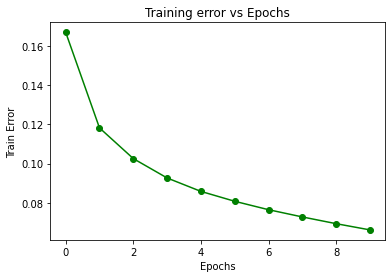

In [ ]:
plt.plot(train_error, 'go-',label='Train Error')
plt.title('Training error vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Train Error')
plt.show()

In [ ]:
model = MNISTalgorithm([784, 'sigmoid', 500, 'sigmoid', 100, 'sigmoid',50, 'softmax', 10], epochs=10, alpha=0.1, batch_size=100)
history,train_error, trained_thetas = model.train(train_images_new, train_labels, test_images_new, test_labels)

Epoch =  1
Loss =  -458.0032891124368
 Accuracy in training 0.53925
 Error in training
Accuracy in testing 0.545
Epoch =  2
Loss =  -204.52851429217665
 Accuracy in training 0.7620833333333333
 Error in training
Accuracy in testing 0.7659
Epoch =  3
Loss =  -137.6286784154471
 Accuracy in training 0.8480666666666666
 Error in training
Accuracy in testing 0.8511
Epoch =  4
Loss =  -111.08819318742216
 Accuracy in training 0.8745
 Error in training
Accuracy in testing 0.8775
Epoch =  5
Loss =  -98.06064467506035
 Accuracy in training 0.889
 Error in training
Accuracy in testing 0.8922
Epoch =  6
Loss =  -89.55431720698222
 Accuracy in training 0.8978833333333334
 Error in training
Accuracy in testing 0.9006
Epoch =  7
Loss =  -82.97916540297301
 Accuracy in training 0.90535
 Error in training
Accuracy in testing 0.9068
Epoch =  8
Loss =  -77.4312667952432
 Accuracy in training 0.9111833333333333
 Error in training
Accuracy in testing 0.9111
Epoch =  9
Loss =  -72.5383555619906
 Accuracy 

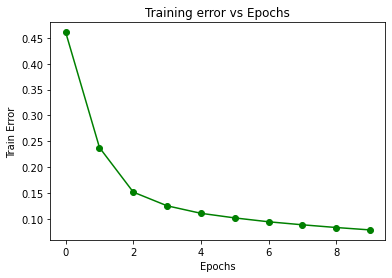

In [ ]:
plt.plot(train_error, 'go-',label='Train Error')
plt.title('Training error vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Train Error')
plt.show()

In [ ]:
model = MNISTalgorithm([784, 'relu', 500, 'relu', 100, 'relu',50, 'softmax', 10], epochs=10, alpha=0.1, batch_size=100)
history,train_error, trained_thetas = model.train(train_images_new, train_labels, test_images_new, test_labels)

Epoch =  1
Loss =  -53.11912384498433
 Accuracy in training 0.9344833333333333
 Error in training
Accuracy in testing 0.9355
Epoch =  2
Loss =  -35.973665515417274
 Accuracy in training 0.9563333333333334
 Error in training
Accuracy in testing 0.951
Epoch =  3
Loss =  -25.32515862182808
 Accuracy in training 0.9692666666666667
 Error in training
Accuracy in testing 0.9611
Epoch =  4
Loss =  -18.90054135441661
 Accuracy in training 0.9771166666666666
 Error in training
Accuracy in testing 0.966
Epoch =  5
Loss =  -15.367183270618144
 Accuracy in training 0.9807666666666667
 Error in training
Accuracy in testing 0.9681
Epoch =  6
Loss =  -11.844983985918667
 Accuracy in training 0.9856166666666667
 Error in training
Accuracy in testing 0.9705
Epoch =  7
Loss =  -10.050814040650394
 Accuracy in training 0.9874
 Error in training
Accuracy in testing 0.971
Epoch =  8
Loss =  -8.07802516644653
 Accuracy in training 0.98985
 Error in training
Accuracy in testing 0.9718
Epoch =  9
Loss =  -6.7

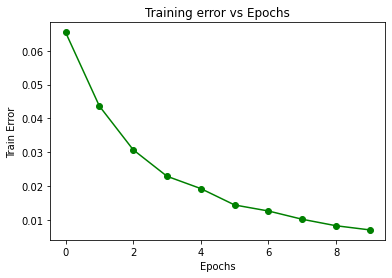

In [ ]:
plt.plot(train_error, 'go-',label='Train Error')
plt.title('Training error vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Train Error')
plt.show()


--> 
1. For MNIST dataset with architecture(784->sigmoid -> 500 -> sigmoid -> 50 ->softmax -> 10), the train error wrt epoch is plotted above as well as printed out. This experiment gives train accuracy = 0.9337 and test accuracy = 0.9344 (as printed above).

2. 

a) Adding a hidden layer of 100 units, architecture((784->sigmoid -> 500 ->sigmoid -> 100-> sigmoid -> 50 ->softmax -> 10) gives train accuracy = 0.9210 and test accuracy = 0.9207(as printed above). The train error wrt epoch is plotted above as well as printed out. Using Relu instead of softmax in this architecture gives train accuracy = 0.9930 and test accuracy = 0.9715 (as printed above). The train error wrt epoch is plotted above as well as printed out.

b) From the above experiments, it is observed that the accuracy in training and testing stabilizes after around 8 epochs. Training the model further might increase the chances of overfitting. 



# Part 2: Training an Image Classifier




##Overview
CIFAR10 dataset will be used to train an image classifier.


##Data
Using `torchvision`, it’s extremely easy to load `CIFAR10`.

In [ ]:
## The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


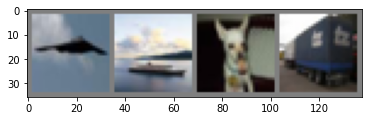

plane ship  dog   truck


In [ ]:
## Let us show some of the training images, for fun.

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

##Code 

###Define a Convolutional Neural Network
Create a neural network that take 3-channel images. It should go as Conv2d --> ReLU --> MaxPool2d --> Conv2d --> ReLU --> MaxPool2d --> Flatten --> Linear --> ReLU --> Linear --> ReLU --> Linear

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        ## TODO: Add layers to your neural net.
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        ## TODO: run forward pass as mentioned above.
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
print(device)

cuda:0


###Define a Loss function and optimizer

Let’s use a Classification Cross-Entropy loss and SGD with momentum. (Feel free to experiment with other loss functions and optimizers to observe differences)

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss() ## TODO: Add loss function
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) ## TODO: Add optimizer

###Train the network

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [ ]:
epochs = 15 ## TODO: define number of epochs to train
loss_list =[]
accuracy_list =[]
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels =  data[0].to(device), data[1].to(device)

        # TODO: add line to zero the parameter gradients below
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    loss_list.append(running_loss)

    ## evaluate the model for each epoch
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    with torch.no_grad():
      for data in testloader:
          images, labels = data[0].to(device), data[1].to(device)
          outputs = net(images)
          _, predictions = torch.max(outputs, 1)
          # collect the correct predictions for each class
          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1
    accuracy = []
    for classname, correct_count in correct_pred.items():
      accuracy.append(100 * float(correct_count) / total_pred[classname])
    accuracy_list.append(np.mean(accuracy))

print('Finished Training')

## Let’s quickly save our trained model:

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

[1,  2000] loss: 2.165
[1,  4000] loss: 1.837
[1,  6000] loss: 1.644
[1,  8000] loss: 1.575
[1, 10000] loss: 1.510
[1, 12000] loss: 1.478
[2,  2000] loss: 1.396
[2,  4000] loss: 1.398
[2,  6000] loss: 1.361
[2,  8000] loss: 1.360
[2, 10000] loss: 1.326
[2, 12000] loss: 1.321
[3,  2000] loss: 1.226
[3,  4000] loss: 1.219
[3,  6000] loss: 1.250
[3,  8000] loss: 1.216
[3, 10000] loss: 1.229
[3, 12000] loss: 1.193
[4,  2000] loss: 1.101
[4,  4000] loss: 1.127
[4,  6000] loss: 1.142
[4,  8000] loss: 1.146
[4, 10000] loss: 1.127
[4, 12000] loss: 1.141
[5,  2000] loss: 1.029
[5,  4000] loss: 1.070
[5,  6000] loss: 1.066
[5,  8000] loss: 1.080
[5, 10000] loss: 1.081
[5, 12000] loss: 1.076
[6,  2000] loss: 0.982
[6,  4000] loss: 1.000
[6,  6000] loss: 1.020
[6,  8000] loss: 1.022
[6, 10000] loss: 1.017
[6, 12000] loss: 1.022
[7,  2000] loss: 0.928
[7,  4000] loss: 0.952
[7,  6000] loss: 0.958
[7,  8000] loss: 0.979
[7, 10000] loss: 0.993
[7, 12000] loss: 0.972
[8,  2000] loss: 0.891
[8,  4000] 

###Test the network on the test data
We have trained the network over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 60.3 %
Accuracy for class: car   is 75.1 %
Accuracy for class: bird  is 54.5 %
Accuracy for class: cat   is 42.5 %
Accuracy for class: deer  is 51.9 %
Accuracy for class: dog   is 45.7 %
Accuracy for class: frog  is 73.1 %
Accuracy for class: horse is 57.4 %
Accuracy for class: ship  is 78.5 %
Accuracy for class: truck is 66.0 %


In [ ]:
def confusion_matrix(testloader, classes = 10):
  matrix = np.zeros((classes, classes))
  with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
          matrix[label][prediction] += 1
  return matrix

def plot_loss(loss_tracker):
  # print(loss_tracker)
  plt.figure()
  plt.title('Loss over epochs')
  plt.plot(loss_tracker)

def plot_accuracy(accuracy_tracker):
  # print(accuracy_tracker)
  plt.figure()
  plt.title('Accuracy over epochs')
  plt.plot(accuracy_tracker)

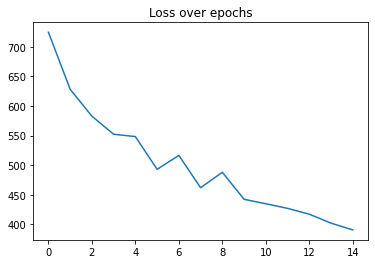

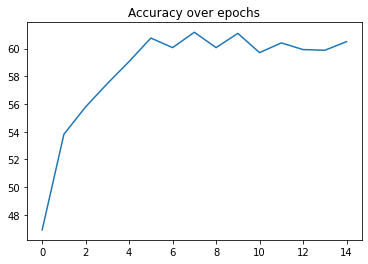

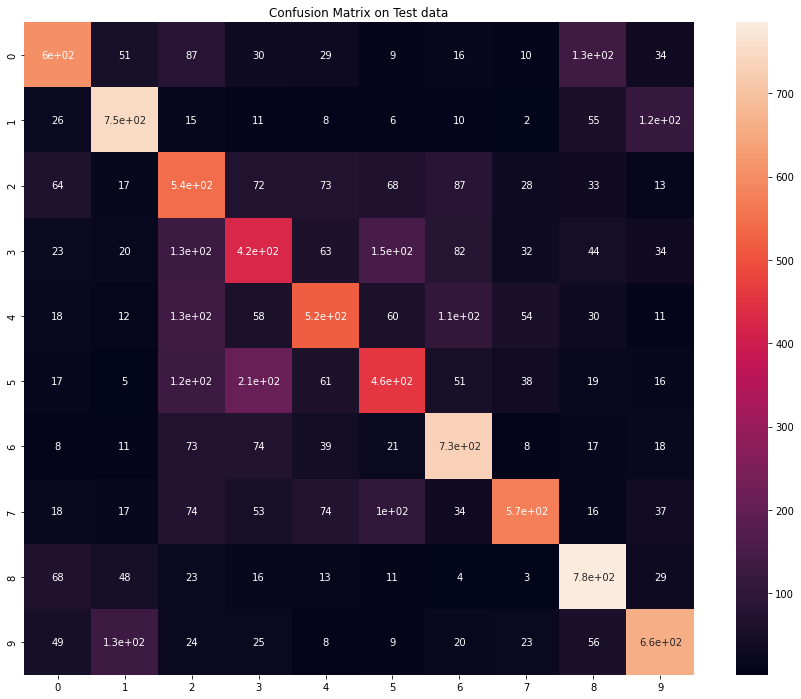

In [ ]:
cm = confusion_matrix(testloader)
plot_loss(loss_list)
plot_accuracy(accuracy_list)
plt.figure(figsize = (15,12))

ax = plt.axes()
sns.heatmap(cm,annot = True, ax = ax)
ax.set_title('Confusion Matrix on Test data')
plt.show()


# Part 3: Semantic Segmentation

## Overview
Semantic Segmentation is an image analysis task in which we classify each pixel in the image into a class.


## Data



In [ ]:
import os 
import tarfile
import shutil
import urllib.request

url='http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar'
path='VOC'
def get_archive(path,url):
  try:
    os.mkdir(path)
  except:
    path=path
  
  filename='devkit'
  urllib.request.urlretrieve(url,f"{path}/{filename}.tar")
 
get_archive(path,url)
def extract(path):
  tar_file=tarfile.open(f"{path}/devkit.tar")
  tar_file.extractall('./')
  tar_file.close()
  shutil.rmtree(path)

extract(path)

## Helper Functions

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import models
import torchvision.transforms as T
import numpy as np
import cv2

"""Various RGB palettes for coloring segmentation labels."""
VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]


VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

## Code

### 1. Implement Data Loader for training and validation

In [ ]:
import os 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# You can modify this class 
class VocDataset(Dataset):
  def __init__(self, dir, color_map):
    self.root=os.path.join(dir,'VOCdevkit/VOC2007')
    self.target_dir=os.path.join(self.root,'SegmentationClass')
    self.images_dir=os.path.join(self.root,'JPEGImages')
    file_list = os.path.join(self.root,'ImageSets/Segmentation/trainval.txt')
    self.files = [line.rstrip() for line in tuple(open(file_list, "r"))]
    self.color_map=color_map

  def convert_to_segmentation_mask(self,mask):
    # This function converts color channels of semgentation masks to number of classes
    # Semantic Segmentation requires a segmentation mask to be a NumPy array with the shape
    # This part is implemented for displaying colorized results in subpart 3
    #      :   
    height, width = mask.shape[:2]
    segmentation_mask = np.zeros((height, width, len(self.color_map)), dtype=np.float32)
    for label_index, label in enumerate(self.color_map):
          segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
    return segmentation_mask

  def __getitem__(self,index):
    #      :
    image_id=self.files[index]
    image_path=os.path.join(self.images_dir,f"{image_id}.jpg")
    label_path=os.path.join(self.target_dir,f"{image_id}.png")
    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image=cv2.resize(image,(256,256))
    image=torch.tensor(image).float()
    label=cv2.imread(label_path)
    label=cv2.cvtColor(label,cv2.COLOR_BGR2RGB)
    label=cv2.resize(label,(256,256))
    label = self.convert_to_segmentation_mask(label)
    label=torch.tensor(label).float()
    return image, label

  def __len__(self):
    return len(self.files)

###2. Define model and training code 
Implement FCN-32 model. You can use encoder as pretrained model provided by torchvision.       

In [ ]:
# Reference used for FCN32 class: https://github.com/pochih/FCN-pytorch
import torch
class FCN32(torch.nn.Module):
  def __init__(self, pretrained_net, n_class):
    super().__init__()
    self.n_class = n_class
    self.pretrained_net = pretrained_net
    self.relu    = nn.ReLU(inplace=True)
    self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn1     = nn.BatchNorm2d(512)
    self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn2     = nn.BatchNorm2d(256)
    self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn3     = nn.BatchNorm2d(128)
    self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn4     = nn.BatchNorm2d(64)
    self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn5     = nn.BatchNorm2d(32)
    self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

  def forward(self, x):
    output = self.pretrained_net(x)
    # print(output.size)
    x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)

    score = self.bn1(self.relu(self.deconv1(x5)))     # size=(N, 512, x.H/16, x.W/16)
    score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
    score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
    score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
    score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
    score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

    return score  # size=(N, n_class, x.H/1, x.W/1)

class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x

        return output


ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

 Training code for the semantic segmentation model. Implment both training and validation parts.  

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Library for calculatin iou
!pip install git+https://github.com/qubvel/segmentation_models.pytorch
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-fp97jbd8
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-fp97jbd8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 376 kB 28.9 MB/s 
     |████████████████████████████████| 58 kB 7.1 MB/s 
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.3.1-py3-none-any.whl size=102071 sha256=359349d74c7886cda86805c5d7a7d29f7c04130126c46303d473f926b3666966
  Stored in directory: /tmp/pip-ephem-wheel-cache-dgkwm8zl/wheels/5b/bd/df/041378eb4d7881115c6dcdf2ca35ddcb188441321e8a887618
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=b54f744ec584a6340b1c9

In [ ]:
from inspect import modulesbyfile
data=VocDataset('/content',VOC_COLORMAP)
train_set,val_set = torch.utils.data.random_split(data,[int(len(data)*0.9),round(len(data)*0.1)+1])
train_loader = DataLoader(train_set,batch_size=3,shuffle=True)
val_loader = DataLoader(val_set,batch_size=3,shuffle=False)
print("Length of train set:", len(train_set), "Length of test set:", len(val_set))
vgg_model = VGGNet(requires_grad=True)
n_class = 21
fcn=FCN32(pretrained_net=vgg_model, n_class=n_class)
fcn=fcn.to(device)
metrics = smp.utils.metrics.IoU(eps=1.)
optimizer=torch.optim.Adam(fcn.parameters(),lr=0.00001)
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=3,verbose=True)
criterion = nn.CrossEntropyLoss() 

Length of train set: 379 Length of test set: 43


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
def train(model,optim,loss_f,epochs,scheduler,path_for_models):
  try:
    os.mkdir(path_for_models)
  except:
    path_for_models=path_for_models

  min_iou=0.3
  for epoch in tqdm(range(epochs)):
    for (X_train,y_train) in train_loader:
      X_train, y_train=X_train.to(device), y_train.to(device)
      X_train = X_train.permute(0, 3, 1, 2)
      y_train = y_train.permute(0, 3, 1, 2)
      y_pred=model(X_train)
      loss=loss_f(y_pred,y_train)
      optim.zero_grad()
      loss.backward()
      optim.step()
    ious=[]
    val_losses=[]
    with torch.no_grad():
      for b,(X_test,y_test) in enumerate(val_loader):
        X_test,y_test=X_test.to(device),y_test.to(device)
        X_test = X_test.permute(0, 3, 1, 2)
        y_test = y_test.permute(0, 3, 1, 2)
        y_val=model(X_test)
        val_loss=loss_f(y_val,y_test)
        val_losses.append(val_loss)
        iou_=metrics(y_val,y_test)
        ious.append(iou_)
      ious=torch.tensor(ious)
      val_losses=torch.tensor(val_losses)
      scheduler.step(val_losses.mean())
      if ious.mean() > min_iou:
        min_iou=ious.mean()
        torch.save(model.state_dict(),f"{path_for_models}/fcnmodel.pt")
    print(f"epoch : {epoch:2} train_loss: {loss:10.4} , val_loss : {val_losses.mean()} val_iou: {ious.mean()}")
  return model

epochs = 20

model = train(fcn,optimizer,criterion,epochs,scheduler,'models')

  5%|▌         | 1/20 [00:35<11:15, 35.54s/it]

epoch :  0 train_loss:      2.801 , val_loss : 2.807312250137329 val_iou: 0.10119188576936722


 10%|█         | 2/20 [01:03<09:14, 30.81s/it]

epoch :  1 train_loss:      2.807 , val_loss : 2.5811140537261963 val_iou: 0.15227918326854706


 15%|█▌        | 3/20 [01:31<08:23, 29.60s/it]

epoch :  2 train_loss:      2.064 , val_loss : 2.433985471725464 val_iou: 0.17096783220767975


 20%|██        | 4/20 [02:01<07:55, 29.71s/it]

epoch :  3 train_loss:      2.408 , val_loss : 2.322216272354126 val_iou: 0.18005545437335968


 25%|██▌       | 5/20 [02:28<07:12, 28.84s/it]

epoch :  4 train_loss:      1.862 , val_loss : 2.247483730316162 val_iou: 0.18989379703998566


 30%|███       | 6/20 [02:57<06:43, 28.80s/it]

epoch :  5 train_loss:      1.942 , val_loss : 2.2011563777923584 val_iou: 0.1974218338727951


 35%|███▌      | 7/20 [03:24<06:08, 28.36s/it]

epoch :  6 train_loss:      1.654 , val_loss : 2.168079376220703 val_iou: 0.20763300359249115


 40%|████      | 8/20 [03:51<05:36, 28.04s/it]

epoch :  7 train_loss:      3.039 , val_loss : 2.114964008331299 val_iou: 0.22328869998455048


 45%|████▌     | 9/20 [04:19<05:06, 27.83s/it]

epoch :  8 train_loss:      1.519 , val_loss : 2.0927093029022217 val_iou: 0.23376445472240448


 50%|█████     | 10/20 [04:48<04:41, 28.12s/it]

epoch :  9 train_loss:      2.523 , val_loss : 2.069371223449707 val_iou: 0.2407316416501999


 55%|█████▌    | 11/20 [05:15<04:10, 27.85s/it]

epoch : 10 train_loss:      2.536 , val_loss : 2.0276551246643066 val_iou: 0.24983789026737213


 60%|██████    | 12/20 [05:42<03:41, 27.71s/it]

epoch : 11 train_loss:      2.063 , val_loss : 2.0094053745269775 val_iou: 0.2572217285633087


 65%|██████▌   | 13/20 [06:11<03:16, 28.10s/it]

epoch : 12 train_loss:     0.9503 , val_loss : 2.0019021034240723 val_iou: 0.2637808918952942


 70%|███████   | 14/20 [06:38<02:47, 27.84s/it]

epoch : 13 train_loss:      1.687 , val_loss : 1.970921277999878 val_iou: 0.26955193281173706


 75%|███████▌  | 15/20 [07:06<02:18, 27.63s/it]

epoch : 14 train_loss:       1.74 , val_loss : 1.95358407497406 val_iou: 0.27092620730400085


 80%|████████  | 16/20 [07:33<01:50, 27.60s/it]

epoch : 15 train_loss:       1.56 , val_loss : 1.936625599861145 val_iou: 0.2731451988220215


 85%|████████▌ | 17/20 [08:02<01:23, 28.00s/it]

epoch : 16 train_loss:      1.815 , val_loss : 1.9207557439804077 val_iou: 0.2718018591403961


 90%|█████████ | 18/20 [08:29<00:55, 27.79s/it]

epoch : 17 train_loss:      1.546 , val_loss : 1.911818265914917 val_iou: 0.2728131115436554


 95%|█████████▌| 19/20 [08:57<00:27, 27.69s/it]

epoch : 18 train_loss:      1.696 , val_loss : 1.8888967037200928 val_iou: 0.27214473485946655


100%|██████████| 20/20 [09:26<00:00, 28.31s/it]

epoch : 19 train_loss:      2.541 , val_loss : 1.8739763498306274 val_iou: 0.2711314558982849


### 3. Inference for semantic segmentation

Implement the inference code for semantic segmentation. Display the visualization results of the model. Plot the image and colorized image.

In [ ]:
#      :
import imageio
def decode_segmap(image,colors, nc=21):
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  # image.unsqueeze(-1)
  for l in range(0,nc):
    idx = image == l
    r[idx] = colors[l][ 0]
    g[idx] = colors[l][ 1]
    b[idx] = colors[l][ 2]
  rgb = np.stack([r, g, b], axis=2)
  return rgb

# Displaying for 5 images
img_list =[]
test_list =[]
for b,(X_test,y_test) in enumerate(val_loader):
  img = X_test.numpy()
  test_list.append(img)
  X_test,y_test=X_test.to(device),y_test.to(device)
  X_test = X_test.permute(0, 3, 1, 2)
  y_test = y_test.permute(0, 3, 1, 2)
  y_val=model(X_test)
  predict = torch.argmax(y_val, dim=1).detach().cpu().numpy()
  img_list.append(predict)
  if b == 4 :
    break


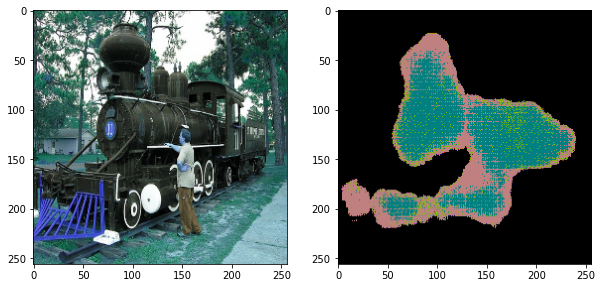

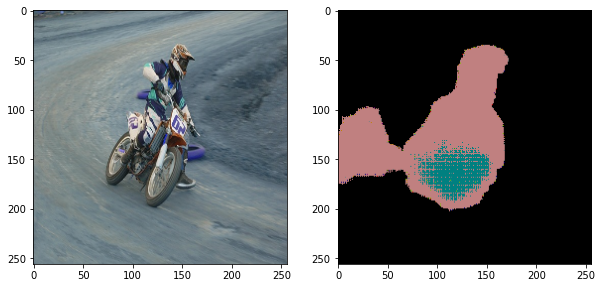

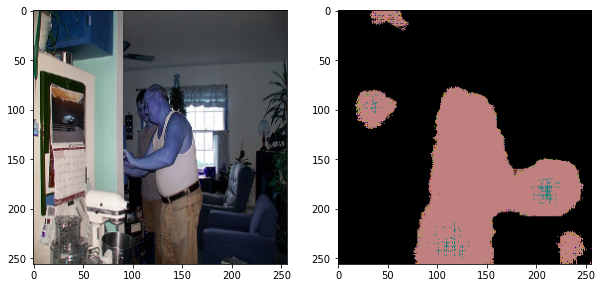

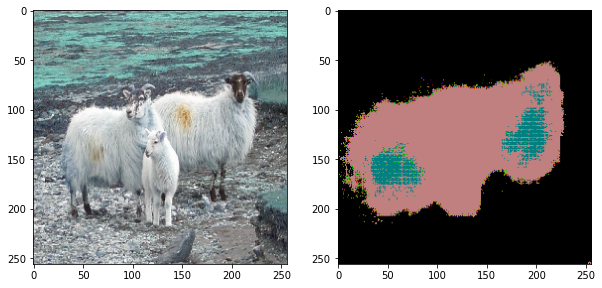

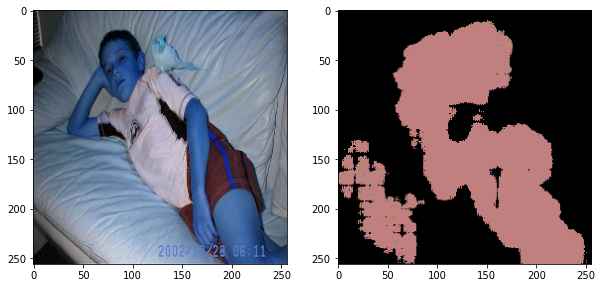

In [ ]:
for i in range(5):
  rgb = decode_segmap(img_list[i][1], VOC_COLORMAP)
  plt.figure(figsize = (10,5))
  plt.subplot(1,2,1)
  image_rgb = cv2.cvtColor(test_list[i][1], cv2.COLOR_RGB2BGR)
  # image_rgb = test_list[i][1]
  plt.imshow((image_rgb ).astype(np.uint8))
  plt.subplot(1,2,2)
  plt.imshow(rgb)
  plt.show()



-->
* In classification, an input image is downsampled and is passed through convolution layers and fully connected labels to predict one label for an input image. However in semantic segmentation, we need to classify the object class for each pixel within an image, i.e each pixel has a label. In this case, if we modify the Fully connected layers of the classification problem above to 1x1 convolution layers and downsample the input image, the output size would be smaller than the input image, but give multiple labels as we want. If the output is upsampled, we get a pixelwise label map, same size as the input image. The various FCN models use variations of this described model. For eg, FCN32s, 32x upsampling is done. It should also be noted that output from shallower layers have more location information. 
* IoU stands for intersection over union. IoU is the area of overlap between the predicted segmentation and the ground truth divided by the area of union between the predicted segmentation and ground truth. IoU value is usually lesser than pixel accuracy, but as a metric it is better way of evaluating segmentation models. 

## References
* Refer to original paper FCNet : https://arxiv.org/abs/1411.4038
* Figures for FCNet Structure: https://towardsdatascience.com/review-fcn-semantic-segmentation-eb8c9b50d2d1
* PyTorch Tutorial for Image semgnetation: https://towardsdatascience.com/train-neural-net-for-semantic-segmentation-with-pytorch-in-50-lines-of-code-830c71a6544f